In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



2024-03-14 13:20:39.211530: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 13:20:39.243016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 13:20:39.852340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
game_threshold = 4 # minimum number of games to be in the dataset
test_size = 0.1 # % of the dataset is used for testing
ModelHasBot = True #  if True, the bot is considered as a player - to consider bot statistics in games 2vs3 or 3vs4
timeStart ='' #'2023-03-01' # start date of the dataset
present_players = ['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун','Сеньор','Юран']

# 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша', 'Ондрей', 'Савва', 'Сеньор', 'Юран'


# Data preprocessing

In [3]:
dataset = pd.read_csv('data.csv') 
columnsPlayers = ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
columnsTeam1 = ["Player1","Player2","Player3","Player4"]
columnsTeam2 = ["Player5","Player6","Player7","Player8"]

In [4]:
dataset["Map"] = dataset["Map"].str.lower() # convert all maps to lower case
dataset['Date'] = pd.to_datetime(dataset['Date'],format='%d.%m.%Y') # convert date to datetime
dataset=dataset.drop_duplicates(subset=['Date','Map']) # drop duplicates with same date and map
dataset.to_csv('new_data.csv',index=False) # save the new dataset
dataset.drop(columns=['link','Recorder','vs'],   inplace=True) # drop columns that are not needed

#  drop entries which were played before the start date
if timeStart != '':
    dataset = dataset[dataset['Date'] >= timeStart]



### Add column with number of maps in each campaign

In [5]:
map_weights = {
'ливень':5,
'кровавая жатва':5, 
'переход':3,
'мрачный карнавал':5,
'холодный ручей':4,
'похоронный звон':5,
'приход':5,
'смерть в воздухе':5,
'нет милосердию':5,
'вымерший центр':4,
'болотная лихорадка':4,
'последний рубеж':2,
'жертва':3,
'роковой полет':5}

def map_weight(map):
    return map_weights[map]

dataset["Map_weight"] = dataset["Map"].apply(map_weight)
dataset["Map_weight"] = dataset["Map_weight"]/ dataset["Map_weight"].max()# scale weight

dataset.Map.value_counts()

Map
смерть в воздухе      13
нет милосердию        13
переход               12
мрачный карнавал      12
приход                11
похоронный звон       10
ливень                 9
кровавая жатва         9
вымерший центр         9
холодный ручей         7
жертва                 6
болотная лихорадка     4
последний рубеж        4
роковой полет          3
Name: count, dtype: int64

#### Unique players and cleaning those with small statistics

In [6]:
# unique players from all 8 columns ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
players = np.unique(dataset[columnsPlayers].values)
players = pd.DataFrame(players, columns=["Player"])
# filter players that have played more than 'game_threshold' games
players = players[players["Player"].map(dataset[columnsPlayers].stack().value_counts()) >= game_threshold]
players = players["Player"].values

# remove rows with players not in the list
dataset = dataset[dataset[columnsPlayers].isin(players).all(axis=1)]

if not ModelHasBot: # remove bot from the list of players
    players = players[players != 'Бот']
players

array(['Бот', 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша',
       'Ондрей', 'Савва', 'Сеньор', 'Юран'], dtype=object)

In [7]:
remove_players = ['Ондрей/Джун', 'Ондрей/Сеньор', 'Марина']
# drop rows with some chosen remove_players in any of the 8 columns
def drop_players(row):
    for player in remove_players:
        if player in row.values:
            return False
    return True

dataset.drop(dataset[~dataset.apply(drop_players, axis=1)].index, inplace=True)

players = np.unique(dataset[["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]].values)

#  delete "Bot" from list
players = players[players != 'Бот']
players

array(['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша', 'Ондрей',
       'Савва', 'Сеньор', 'Юран'], dtype=object)

In [8]:
# randonly assign 1 or 2 to TeamWon column
dataset["TeamWon"] = np.random.randint(1, 3, dataset.shape[0])
dataset

,Date,Map,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Map_weight,TeamWon
0,2024-03-09,ливень,Ден,Гриша,Ондрей,Юран,Сеньор,Савва,Данил,Бот,1.0,2
3,2024-03-03,кровавая жатва,Данил,Вадим,Сеньор,Савва,Гриша,Миша,Ден,Бот,1.0,1
6,2024-03-03,переход,Вадим,Сеньор,Юран,Гриша,Ден,Данил,Савва,Миша,0.6,1
8,2024-03-02,мрачный карнавал,Данил,Гриша,Сеньор,Савва,Вадим,Миша,Ваня,Бот,1.0,2
11,2024-02-25,холодный ручей,Ден,Вадим,Гриша,Бот,Юран,Сеньор,Ваня,Бот,0.8,2
...,...,...,...,...,...,...,...,...,...,...,...,...
225,2022-12-10,мрачный карнавал,Сеньор,Ден,Гриша,Ондрей,Джун,Миша,Данил,Бот,1.0,2
227,2022-12-11,похоронный звон,Сеньор,Миша,Гриша,Бот,Вадим,Ден,Ваня,Бот,1.0,1
229,2022-12-11,кровавая жатва,Ден,Сеньор,Джун,Ваня,Ондрей,Миша,Гриша,Бот,1.0,2
233,2022-11-03,кровавая жатва,Миша,Ондрей,Данил,Бот,Джун,Вадим,Ден,Бот,1.0,1


In [9]:
players

array(['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша', 'Ондрей',
       'Савва', 'Сеньор', 'Юран'], dtype=object)

In [10]:
# Players from "Team 1" are Player1, Player2, Player3, Player4
# Players from "Team 2" are Player5, Player6, Player7, Player8
# TeamWon column is the team that won the game
#  assign to player in which team he was

from keras.utils import to_categorical

for player in players:
    # make default value 0
    dataset[player] = 0
    dataset.loc[(dataset['Player1'] == player) | (dataset['Player2'] == player) | (dataset['Player3'] == player) | (dataset['Player4'] == player), player] = 1
    dataset.loc[(dataset['Player5'] == player) | (dataset['Player6'] == player) | (dataset['Player7'] == player) | (dataset['Player8'] == player), player] = 2
    if player=="Бот":
        dataset.loc[(dataset['Player4'] == "Бот") & (dataset['Player8'] == "Бот"), 'Бот'] = 0 # remove bot from statistics of 3 vs 3
    # now make it categorical
    
    labels=to_categorical(dataset[player])

    # make labels as pandas dataframe
    labels = pd.DataFrame(labels, columns=[player+"_abcent", player+"_team1", player+"_team2"])
    labels.drop(columns=[player+"_abcent"], inplace=True)

    # add to dataset
    dataset.reset_index(drop=True, inplace=True)
    labels.reset_index(drop=True, inplace=True)

    dataset = pd.concat([dataset, labels], axis=1)
    print ("dataset after adding labels")
    print(dataset.shape)

    # drop original column
    dataset.drop(columns=[player], inplace=True)


dataset after adding labels
(115, 15)
dataset after adding labels
(115, 17)
dataset after adding labels
(115, 19)
dataset after adding labels
(115, 21)
dataset after adding labels
(115, 23)
dataset after adding labels
(115, 25)
dataset after adding labels
(115, 27)
dataset after adding labels
(115, 29)
dataset after adding labels
(115, 31)
dataset after adding labels
(115, 33)
dataset after adding labels
(115, 35)


In [11]:
dataset.shape

(115, 34)

In [12]:
dataset

,Date,Map,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Map_weight,TeamWon,Вадим_team1,Вадим_team2,Ваня_team1,Ваня_team2,Гриша_team1,Гриша_team2,Данил_team1,Данил_team2,Ден_team1,Ден_team2,Джун_team1,Джун_team2,Миша_team1,Миша_team2,Ондрей_team1,Ондрей_team2,Савва_team1,Савва_team2,Сеньор_team1,Сеньор_team2,Юран_team1,Юран_team2
0,2024-03-09,ливень,Ден,Гриша,Ондрей,Юран,Сеньор,Савва,Данил,Бот,1.0,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2024-03-03,кровавая жатва,Данил,Вадим,Сеньор,Савва,Гриша,Миша,Ден,Бот,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2024-03-03,переход,Вадим,Сеньор,Юран,Гриша,Ден,Данил,Савва,Миша,0.6,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-03-02,мрачный карнавал,Данил,Гриша,Сеньор,Савва,Вадим,Миша,Ваня,Бот,1.0,2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2024-02-25,холодный ручей,Ден,Вадим,Гриша,Бот,Юран,Сеньор,Ваня,Бот,0.8,2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2022-12-10,мрачный карнавал,Сеньор,Ден,Гриша,Ондрей,Джун,Миша,Данил,Бот,1.0,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111,2022-12-11,похоронный звон,Сеньор,Миша,Гриша,Бот,Вадим,Ден,Ваня,Бот,1.0,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
112,2022-12-11,кровавая жатва,Ден,Сеньор,Джун,Ваня,Ондрей,Миша,Гриша,Бот,1.0,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
113,2022-11-03,кровавая жатва,Миша,Ондрей,Данил,Бот,Джун,Вадим,Ден,Бот,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#  add data with swapped players to lower values of absent players
swapped = dataset.copy()
swapped[columnsTeam1+columnsTeam2] = swapped[columnsTeam2+columnsTeam1]
# dataset = pd.concat([dataset, swapped])

In [14]:
# # plot individual player winrate during some period
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(8,5))
# slice_duration_days = 20


# def plot_player_winrate(player):
#     player_data = dataset[dataset[player] != 0]
#     player_data = player_data.sort_values(by='Date')
#     player_data = player_data.set_index('Date')

#     player_data["win"] = player_data['TeamWon'] == player_data[player]
#     player_data["win"] = player_data["win"].replace({player:1,0:0})
#     player_data["win"] = player_data["win"].fillna(0)
#     player_data["win"] = player_data["win"].astype(int)

#     player_data["winrate"] = player_data["win"].rolling(f'{slice_duration_days}D').mean()


#     # plot not every entry but only every 10th and skip first 5 entries
        
#     player_data = player_data.iloc[5::1, :]
#     player_data = player_data.reset_index()
#     player_data = player_data.dropna()
#     sns.lineplot(x=player_data['Date'], y=player_data['winrate'], label=player)

# for player in players:
#     plot_player_winrate(player)

# plt.show()




## Train the model

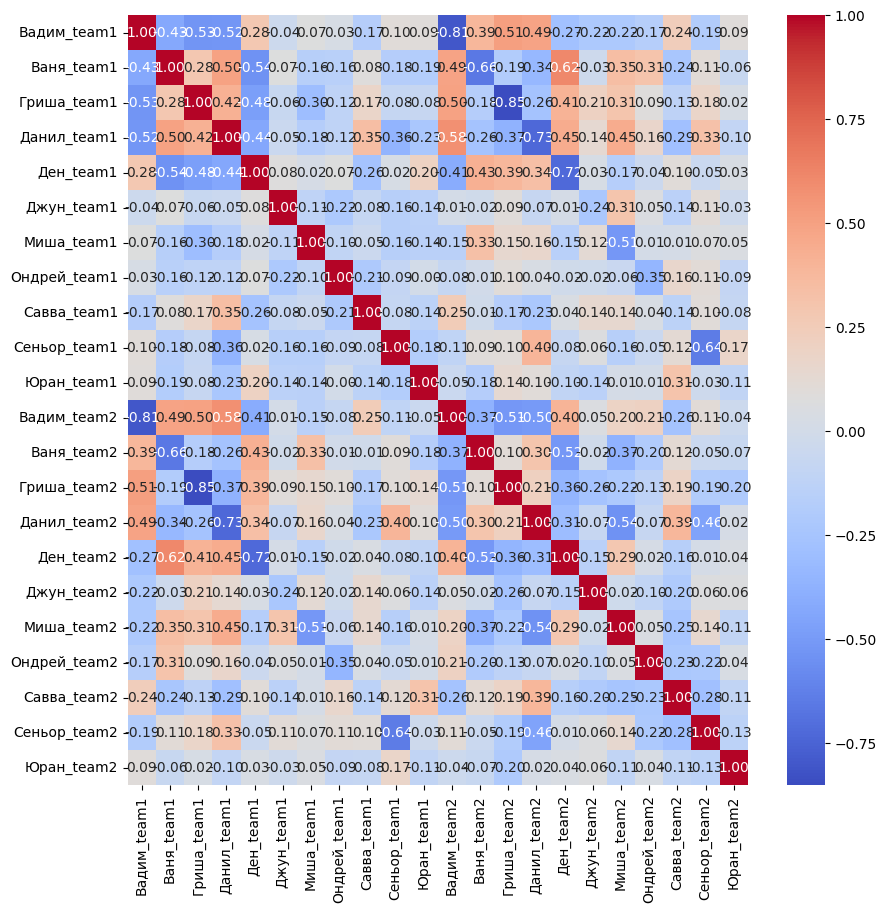

In [15]:
# plot  correlation between  players who won together

players = [player+"_team1" for player in players] + [player+"_team2" for player in players]

#  correlation between  players who won together
correlation = dataset[players].corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()



In [16]:
# split the dataset into train and test
train, test = train_test_split(dataset,  test_size=test_size, random_state=42)

# select the columns to predict
y_train = train['TeamWon']-1  # 0 or 1
y_test = test['TeamWon']-1 # 0 or 1

# select the columns to train the model
X_train = train[players]
w_train = train["Map_weight"]
X_test = test[players]
w_test = test["Map_weight"]

# #  scale the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [17]:
players

['Вадим_team1',
 'Ваня_team1',
 'Гриша_team1',
 'Данил_team1',
 'Ден_team1',
 'Джун_team1',
 'Миша_team1',
 'Ондрей_team1',
 'Савва_team1',
 'Сеньор_team1',
 'Юран_team1',
 'Вадим_team2',
 'Ваня_team2',
 'Гриша_team2',
 'Данил_team2',
 'Ден_team2',
 'Джун_team2',
 'Миша_team2',
 'Ондрей_team2',
 'Савва_team2',
 'Сеньор_team2',
 'Юран_team2']

In [18]:
#  create a model
model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(len(players),), activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',

              # metrics=['accuracy'],
              weighted_metrics=['accuracy']
              )
# train the model
model.fit(X_train,
          y_train, 
          sample_weight=w_train,
          validation_data=(X_test, y_test, w_test), 
          epochs=10)
# test the model
print ("")
print ("Test")
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

2024-03-14 13:20:43.981177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 13:20:43.988536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 13:20:43.988583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 13:20:43.992578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 13:20:43.992620: I tensorflow/compile

Epoch 1/10


2024-03-14 13:20:46.774237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-14 13:20:46.789742: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558bcbd45b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 13:20:46.789778: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-14 13:20:46.800327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 13:20:46.817650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-03-14 13:20:46.908475: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-14 

4/4 [==============================] - 2s 63ms/step - loss: 0.6436 - accuracy: 0.3851 - val_loss: 0.5861 - val_accuracy: 0.6604
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 0.6098 - accuracy: 0.5514 - val_loss: 0.5904 - val_accuracy: 0.6038
Epoch 3/10
4/4 [==============================] - 0s 12ms/step - loss: 0.5946 - accuracy: 0.5711 - val_loss: 0.5893 - val_accuracy: 0.5094
Epoch 4/10
4/4 [==============================] - 0s 14ms/step - loss: 0.5858 - accuracy: 0.5930 - val_loss: 0.5842 - val_accuracy: 0.5094
Epoch 5/10
4/4 [==============================] - 0s 13ms/step - loss: 0.5783 - accuracy: 0.5930 - val_loss: 0.5749 - val_accuracy: 0.5094
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: 0.5722 - accuracy: 0.6149 - val_loss: 0.5720 - val_accuracy: 0.5094
Epoch 7/10
4/4 [==============================] - 0s 13ms/step - loss: 0.5644 - accuracy: 0.6149 - val_loss: 0.5731 - val_accuracy: 0.5094
Epoch 8/10
4/4 [======================

In [20]:
all_results = []
# add bots to the present players if there are less than 8 players
while len(present_players) < 8:
      present_players = present_players + ["Бот"]
print ('present_players are', present_players)


for i in range(0, len(present_players)):
    for j in range(i+1, len(present_players)):
        for k in range(j+1, len(present_players)):
            for l in range(k+1, len(present_players)):
                                team1 = [present_players[i], present_players[j], present_players[k], present_players[l]]
                                # subtract team 1 player form list of present players, "Бот" can be used many times
                                team2 = [x for x in present_players if x not in team1]
                                # if team 2 has less than 4 players, add "Бот" to team 2
                                while len(team2) < 4:
                                    team2.append("Бот")
                                
                                # create a row with the team1 and team2 players
                                row = np.zeros(len(players))
                                for player in team1:
                                    row[players.index(player+"_team1")] = 1
                                for player in team2:
                                    row[players.index(player+"_team2")] = 1
                                row = row.reshape(1, -1)

                                # predict the result
                                result = model.predict(row, verbose=0)
                                all_results.append((team1, team2, result))
# sort the results
all_results.sort(key=lambda x: x[2], reverse=True)
print ("")
print (len(all_results))


present_players are ['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Сеньор', 'Юран']

70


In [21]:
# print the results
for i in range(0, len(all_results)):
    print(all_results[i][0], "vs", all_results[i][1], ":", all_results[i][2][0][0])

['Вадим', 'Ден', 'Джун', 'Сеньор'] vs ['Ваня', 'Гриша', 'Данил', 'Юран'] : 0.6455818
['Вадим', 'Гриша', 'Данил', 'Ден'] vs ['Ваня', 'Джун', 'Сеньор', 'Юран'] : 0.64422226
['Вадим', 'Гриша', 'Ден', 'Сеньор'] vs ['Ваня', 'Данил', 'Джун', 'Юран'] : 0.6383953
['Вадим', 'Ваня', 'Ден', 'Сеньор'] vs ['Гриша', 'Данил', 'Джун', 'Юран'] : 0.63832575
['Вадим', 'Ваня', 'Ден', 'Джун'] vs ['Гриша', 'Данил', 'Сеньор', 'Юран'] : 0.63275427
['Вадим', 'Гриша', 'Ден', 'Джун'] vs ['Ваня', 'Данил', 'Сеньор', 'Юран'] : 0.63269585
['Вадим', 'Данил', 'Ден', 'Сеньор'] vs ['Ваня', 'Гриша', 'Джун', 'Юран'] : 0.62085116
['Гриша', 'Данил', 'Ден', 'Сеньор'] vs ['Вадим', 'Ваня', 'Джун', 'Юран'] : 0.61701536
['Вадим', 'Ваня', 'Гриша', 'Ден'] vs ['Данил', 'Джун', 'Сеньор', 'Юран'] : 0.614361
['Вадим', 'Ваня', 'Джун', 'Сеньор'] vs ['Гриша', 'Данил', 'Ден', 'Юран'] : 0.60401946
['Ваня', 'Гриша', 'Данил', 'Ден'] vs ['Вадим', 'Джун', 'Сеньор', 'Юран'] : 0.59819275
['Ваня', 'Гриша', 'Ден', 'Джун'] vs ['Вадим', 'Данил', 'Се

In [22]:
#  take the middle of the list
middle = len(all_results) // 2
print ("best team by median:")
print(all_results[middle][0], "vs", all_results[middle][1], "with output=", all_results[middle][2][0][0])

#second best team
print ("second best team by median:")
print(all_results[middle-1][0], "vs", all_results[middle-1][1], "with output=", all_results[middle-1][2][0][0])



best team by median:
['Данил', 'Ден', 'Джун', 'Сеньор'] vs ['Вадим', 'Ваня', 'Гриша', 'Юран'] with output= 0.52307564
second best team by median:
['Гриша', 'Ден', 'Джун', 'Юран'] vs ['Вадим', 'Ваня', 'Данил', 'Сеньор'] with output= 0.5251627


In [23]:
# take closest to 50% result
closest = min(all_results, key=lambda x: abs(x[2] - 0.5))
print ("best team by model 50% result:")
print(closest[0], "vs", closest[1], "with output=", closest[2][0][0])

best team by model 50% result:
['Ваня', 'Ден', 'Джун', 'Юран'] vs ['Вадим', 'Гриша', 'Данил', 'Сеньор'] with output= 0.4975772


In [28]:
# make the list of players from table above
old_method_dataset = pd.DataFrame({
    "Player": ["Сеньор", "Гриша", "Миша", "Ваня", "Бот", "Джун", "Данил", "Вадим", "Ондрей", "Юран", "Ден", "Савва"],
    "Games":  [      21,      22,     19,     18,     6,      8,      16,      24,       12,     10,    18,      10],
    "Wins":   [      14,      14,     11,     10,     3,      4,       8,      10,        5,      4,     6,       3]
})

old_method_dataset["Winrate"] = old_method_dataset["Wins"] / old_method_dataset["Games"]
old_method_dataset = old_method_dataset.sort_values(by="Winrate", ascending=False)
old_method_dataset

,Player,Games,Wins,Winrate
0,Сеньор,21,14,0.666667
1,Гриша,22,14,0.636364
2,Миша,19,11,0.578947
3,Ваня,18,10,0.555556
4,Бот,6,3,0.500000
5,Джун,8,4,0.500000
6,Данил,16,8,0.500000
7,Вадим,24,10,0.416667
8,Ондрей,12,5,0.416667
9,Юран,10,4,0.400000


In [37]:
# based on present players and winrate, loop over all possible teams and calculate the total winrate
#  and print the best team
all_teams = []
for i in range(0, len(present_players)):
    for j in range(i+1, len(present_players)):
        for k in range(j+1, len(present_players)):
            for l in range(k+1, len(present_players)):
                team1 = [present_players[i], present_players[j], present_players[k], present_players[l]]
                team2 = [x for x in present_players if x not in team1]
                while len(team2) < 4:
                    team2.append("Бот")
                team1_winrate = old_method_dataset[old_method_dataset["Player"].isin(team1)]["Winrate"].sum()
                team2_winrate = old_method_dataset[old_method_dataset["Player"].isin(team2)]["Winrate"].sum()
                all_teams.append((team1, team1_winrate, team2, team2_winrate))
all_teams.sort(key=lambda x: x[1], reverse=True)
print ("present_players are", present_players)
print ("")
# print the results
for i in range(0, len(all_teams)):
    print(all_teams[i][0], "with winrate=", all_teams[i][1], "vs", all_teams[i][2], "with winrate=", all_teams[i][3])
# median
middle = len(all_teams) // 2
print ("best team by median:")
print(all_teams[middle][0], "with points=", all_teams[middle][3],"vs", all_teams[middle][1], "with points=", all_teams[middle][2])


present_players are ['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Сеньор', 'Юран']

['Ваня', 'Гриша', 'Данил', 'Сеньор'] with winrate= 2.3585858585858586 vs ['Вадим', 'Ден', 'Джун', 'Юран'] with winrate= 1.6500000000000001
['Ваня', 'Гриша', 'Джун', 'Сеньор'] with winrate= 2.3585858585858586 vs ['Вадим', 'Данил', 'Ден', 'Юран'] with winrate= 1.6500000000000001
['Гриша', 'Данил', 'Джун', 'Сеньор'] with winrate= 2.3030303030303028 vs ['Вадим', 'Ваня', 'Ден', 'Юран'] with winrate= 1.7055555555555555
['Вадим', 'Ваня', 'Гриша', 'Сеньор'] with winrate= 2.275252525252525 vs ['Данил', 'Ден', 'Джун', 'Юран'] with winrate= 1.7333333333333332
['Ваня', 'Гриша', 'Сеньор', 'Юран'] with winrate= 2.2585858585858585 vs ['Вадим', 'Данил', 'Ден', 'Джун'] with winrate= 1.75
['Ваня', 'Данил', 'Джун', 'Сеньор'] with winrate= 2.2222222222222223 vs ['Вадим', 'Гриша', 'Ден', 'Юран'] with winrate= 1.7863636363636364
['Вадим', 'Гриша', 'Данил', 'Сеньор'] with winrate= 2.2196969696969697 vs ['Ваня', 'Ден', '

In [40]:
#  print best median result from old method and new method
print ("best team by median from Neural Network:")
print(all_results[middle][0], "vs", all_results[middle][1], "with output=", all_results[middle][2][0][0])
print ("best team by median from Old Method:")
print(all_teams[middle][0], "vs", all_teams[middle][2], "with winrate=", all_teams[middle][3], "vs", all_teams[middle][1])

best team by median from Neural Network:
['Данил', 'Ден', 'Джун', 'Сеньор'] vs ['Вадим', 'Ваня', 'Гриша', 'Юран'] with output= 0.52307564
best team by median from Old Method:
['Данил', 'Ден', 'Джун', 'Сеньор'] vs ['Вадим', 'Ваня', 'Гриша', 'Юран'] with winrate= 2.008585858585859 vs 1.9999999999999998
